**Team Members: Ethan Wong, Timmy Ren, Mason Shu, Medha Nalamada, Carson Mullen, Bethel Kim**

*Note to all: Please pull any changes from the repo before working on this file!*

# Scraping from Edmunds.com

In [88]:
# Installing necessary libraries

# !pip install selenium
# !pip install google-colab-selenium
# !pip install nltk
#!pip install webdriver-manager

In [11]:
# Running necessary libraries

import pandas as pd
import nltk
from nltk.corpus import stopwords
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

from collections import Counter
import re

In [12]:
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(sentences):
    filtered_sentences = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_sentence = ' '.join(filtered_words)
        filtered_sentences.append(filtered_sentence)

    return filtered_sentences

We decided to choose the newest posts for our analyses!

In [20]:
# Set up Selenium to use Chrome browser
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode (without opening a browser window)
chrome_service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

# Access the last page of the discussion
last_page = 435 
url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{last_page}'
driver.get(url)

# Extract elements containing the messages and dates
elements = driver.find_elements("xpath", "//div[contains(@class,'Message') and contains(@class,'userContent')]")
elements2 = driver.find_elements("xpath", "//span[@class='MItem DateCreated']//time")

text = []
dates = []
unique_messages = set()  # Set to track unique messages

for element in elements:
    # Find blockquotes within the element and remove their text
    blockquote_elements = element.find_elements("xpath", ".//blockquote")
    message = element.text

    for blockquote in blockquote_elements:
        message = message.replace(blockquote.text, "")

    if message not in unique_messages:
        text.append(message.strip())
        unique_messages.add(message)

for element in elements2:
    dates.append(element.text)

# Loop through pages in reverse order
for i in range(last_page - 1, 0, -1):
    url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{i}'
    driver.get(url)

    elements = driver.find_elements("xpath", "//div[contains(@class,'Message') and contains(@class,'userContent')]")
    elements2 = driver.find_elements("xpath", "//span[@class='MItem DateCreated']//time")

    for element in elements:
        # Find blockquotes within the element and remove their text
        blockquote_elements = element.find_elements("xpath", ".//blockquote")
        message = element.text
        
        for blockquote in blockquote_elements:
            message = message.replace(blockquote.text, "")
        
        if message not in unique_messages:
            text.append(message.strip())
            unique_messages.add(message)
        if len(text) >= 5000:
            break  # Stop collecting once we have 5000 unique posts

    for element in elements2:
        dates.append(element.text)
        if len(text) >= 5000:
            break  # Stop collecting once we have 5000 unique posts

    if len(text) >= 5000:
        print(f"Collected 5000 unique posts, stopping at page {i+1}")
        break

    print(f"Scraping page {i+1}")

# Close the browser
driver.quit()

# Ensure the lengths of text and dates are the same before saving
if len(text) > len(dates):
    text = text[:len(dates)]
elif len(dates) > len(text):
    dates = dates[:len(text)]

Scraping page 435
Scraping page 434
Scraping page 433
Scraping page 432
Scraping page 431
Scraping page 430
Scraping page 429
Scraping page 428
Scraping page 427
Scraping page 426
Scraping page 425
Scraping page 424
Scraping page 423
Scraping page 422
Scraping page 421
Scraping page 420
Scraping page 419
Scraping page 418
Scraping page 417
Scraping page 416
Scraping page 415
Scraping page 414
Scraping page 413
Scraping page 412
Scraping page 411
Scraping page 410
Scraping page 409
Scraping page 408
Scraping page 407
Scraping page 406
Scraping page 405
Scraping page 404
Scraping page 403
Scraping page 402
Scraping page 401
Scraping page 400
Scraping page 399
Scraping page 398
Scraping page 397
Scraping page 396
Scraping page 395
Scraping page 394
Scraping page 393
Scraping page 392
Scraping page 391
Scraping page 390
Scraping page 389
Scraping page 388
Scraping page 387
Scraping page 386
Scraping page 385
Scraping page 384
Scraping page 383
Scraping page 382
Scraping page 381
Scraping p

In [30]:
# Create a DataFrame and save it to a CSV file
df = pd.DataFrame({'Message': text, 'Date': dates})
df.to_csv('ScrapedData.csv', index=False) # Use this for task A!

# Remove stopwords and save the modified data
text = remove_stopwords(text)
df['Message'] = text
df.to_csv('ScrapedDataMod.csv', index=False) # Use this for task B onwards!

# Task A: Testing Zipf's law econometrically and plotting the most common 100 words in the data against the theoretical prediction of the law.

Note: Stopwords not removed, and stemming or lemmatization not performed.

In [55]:
dfA = pd.read_csv('ScrapedDataMod.csv')

In [56]:
all_text = ' '.join(dfA['Message'].dropna())
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [57]:
word_freq_df

,Word,Frequency
190,car,2831
2,s,2781
84,i,2111
81,like,1750
140,would,1681
...,...,...
10799,leadership,1
10798,atop,1
10797,foes,1
10793,antsy,1


In [58]:
word_freq_df = word_freq_df.reset_index(drop=True)
word_freq_df['rank'] = word_freq_df.index + 1

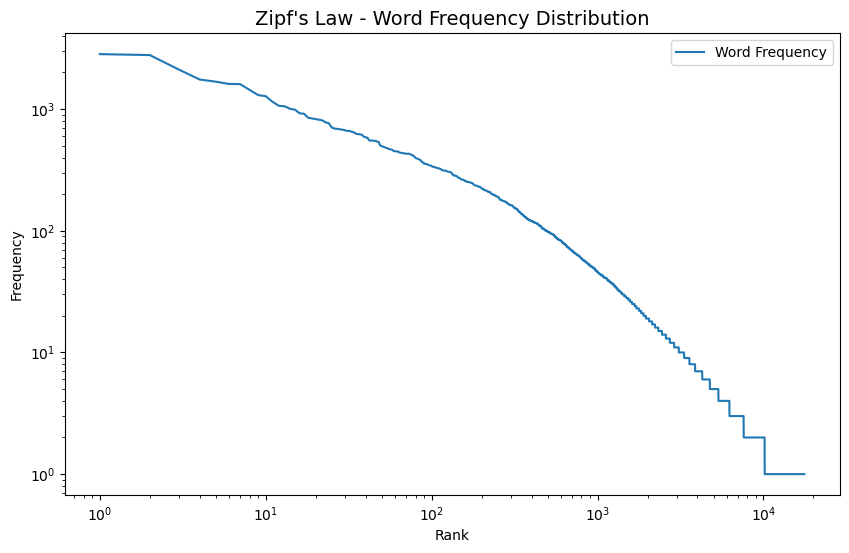

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(word_freq_df['rank'], word_freq_df['Frequency'], label='Word Frequency')

plt.xscale('log')
plt.yscale('log')

plt.title("Zipf's Law - Word Frequency Distribution", fontsize=14)
plt.xlabel("Rank")
plt.ylabel("Frequency")

plt.legend()
plt.show()

# Task B: Finding the top 10 brands from frequency counts.

Note: Stopwords not counted, and analysis is performed at the brand level.

## Replacing car models with brands in the scraped data (without stopwords).

In [101]:
# Load car models and brands data
df2 = pd.read_csv("car_models_and_brands.csv")

In [103]:
# Removing non-car brands from data
to_drop = ['car', 'seat', 'problem', 'sedan']
df2 = df2[~df2['Brand'].isin(to_drop)]

In [107]:
car_brands = df2['Brand'].str.lower().unique()
model_to_brand = dict(zip(df2['Model'].str.lower(), df2['Brand'].str.lower()))
results = []

# Extract car brands from posts
for index, row in df.iterrows():
    message = row['Message']

    found_brands = set([brand for brand in car_brands if brand in message.lower()]) 
    # Bug - if we read in ScrapedDataMod.csv, the above line fails to execute. However, if we don't re-read it in after scapring, this code executes.
    found_models = [model for model in model_to_brand if model in message.lower()]
    found_brands.update([model_to_brand[model] for model in found_models])

    results.append(', '.join(found_brands))

df['Brands'] = results

In [111]:
# Group by brands and count occurrences
df.groupby('Brands').count()

,Message,Date
Brands,,
,1694,1694
acura,38,38
"acura, bmw, infiniti, audi, volkswagen",1,1
"acura, chevrolet, nissan, infiniti, toyota, volkswagen",1,1
"acura, dodge, infiniti, audi, bmw",1,1
...,...,...
"volkwagen, bmw",1,1
"volkwagen, buick",1,1
"volkwagen, sedan",1,1


# Task C: Calculating the lift ratios for associations between the top 10 brands identified in Task A.

Note: Counting of a brand is done once per post, and a message is not counted in the lift calculations if the mentions of the two brands are separated by approximately 5-7 words.

In [ ]:
# Lift values need to be in a table

# Task D: Plotting the brands on a multi-dimensional scaling (MDS) map.

# Task E: Insights from Tasks C and D.

# Task F: Identifying the top 5 most frequently mentioned attributes of features of cars in the discussions and which attributes are strongly associated with which of the 5 brands.

In [15]:
# Need to clarify wording with professor on wording of this question.

# Task G: Advice for Client based on Task F.

# Task H: Identifying the most aspirational brand in the data in terms of people wanting to actually buy or own.

In [ ]:
# Describe analyses
    # Describe how we measured "aspirational" and how we found the most aspirational brand. 
# Describe business implications for this brand